# Modelo de Ising (el problema de Onsanger)

Aquino Chapa Martha Abril

In [1]:
using Plots
using Roots
using BenchmarkTools

In [2]:
#También declaramos las constantes
#definimos la constante de boltzman como 1 para que los resultados tengan mejor visualización
kb = 1
#Se declara con esee valor J por consenso del grupo :)
J=0.5;

Iniciamos creando la red cuadrada de $N^2$ elementos, la cual en vez de presentarla como una matriz será un arreglo

$$RED = [1,2,3,...,N^2] $$

In [3]:
#función que genera una red considerando de manera aleatoria los elememtos de la red: -1 o 1
#El total de elementos en la red es N^2
function generador_de_red(N)
    return  [rand([-1,1]) for i in 1:N^2]
end

generador_de_red (generic function with 1 method)

In [4]:
#Probando la función:
N_prueba=3 
red_prueba = generador_de_red(N_prueba);

Ahora generamos un arreglo en el cual en cada fila se encuentren acomodados los vecinos del i-ésimo elemento. 
Estarán acomodados de la siguiente manera: [vecino de arriba, vecino de la derecha, vecino de abajo, vecino de la izquierda]

In [4]:
function generador_indice_vecinos(red)
    N² = length(red)
    N= Int((N²)^(1/2))
    v = zeros(Int64,(N²,4))
    #v[i] = [arriba, derecha, abajo, izquierda]

    #Obtenemos el arreglado donde acomodamos los situos de los
    
    #Iniciamos a indexar los vecinos de arriba
    for j in 1:N²
        if j+N<= N²
            v[j,1] = j+N 

        elseif j+N>N²
            v[j,1] = j - N*(N-1)
        end

        #Para los vecinos de la derecha
        if j%N != 0 
            v[j,2] = j+1
        elseif j%N ==0
            v[j,2] = j-N+1 
        end


        #Para los vecinos de abajo

        if j-N>=1
            v[j,3] = j-N
        elseif j-N<1
            v[j,3] =j+N*(N-1)
        end

        #Para los vecinos izquierda

        if (j-1)%N != 0
            v[j,4] = j-1
        elseif (j-1)%N ==0
            v[j,4] = j+N-1
        end
    end
    #Regresamos el arreglo donde están los vecinos
    return v
end

generador_indice_vecinos (generic function with 1 method)

In [7]:
#Probando la función con la red de prueba
vecinos_prueba = generador_indice_vecinos(red_prueba);

En el modelo de Ising considerando geometría cuadrada se tiene que la energía de interacción de un elemento con sus vecinos está dada por
$$E= -J\sum_{<ij>}S_iS_j $$

Por lo que la energía de un elemento se calcula con la siguiente función

Creamos una función que nos devuelva la energía total del sistema 

In [7]:
function energia_total_del_sistema(red_lista)
    #generamos los indices de los vecinos
    vecinos_lista = generador_indice_vecinos(red_lista)
    #Creamos un arreglo donde iremos sumando cada elemento de la suma de la energía total
    energia_total = 0
    #Creamos un arreglo que obtenga la energía de interacción de cada elemento de la red
    N² = length(red_lista)
    for i in 1:N²
        #Obtenemos los indices de los vecinos
        vecinosi= vecinos_lista[i]
        for j in vecinosi
            energia_total += red_lista[i]*red_lista[j]
        end
    
    end
    return energia_total*(-J)
end

energia_total_del_sistema (generic function with 1 method)

In [50]:
energia_total_prueba = energia_total_del_sistema(red_prueba)

-3

In [8]:
function magnetizacion(red_lista)
    return sum(red_lista)
end

magnetizacion (generic function with 1 method)

In [31]:
magnetizacion_prueba = magnetizacion(red_prueba)

1

### Implementando el algoritmo de Metropolis

Generando el algoritmo de Metropolis
$$\frac{p_i}{p_j} = e^{(-\beta(E_i-E_j))} $$
y queremos encontrar el estado de equilibrio

In [30]:
function energia_por_elemento(elemento,elemento_indice,vecinos_indices,red_lista,J)### Indice del elemento de 
    #Variable donde se almacenará la suma de los elementos de la energía
    energia_suma = 0
    for i in 1:4
        indice_vecino = Int(vecinos_indices[elemento_indice,i])
        energia_suma += elemento*red_lista[indice_vecino]
    end
    return energia_suma*(-J)
    
end

energia_por_elemento (generic function with 1 method)

In [25]:
#Función que modifica la red para evolucionarla a una red en equilibrio con mayor probabilidad
#Inicia recopilando la red y la temperatura y define Q como 5000 iteraciones por default
function ising(red_inicial,T,Q=7000) 
    #Obtenemos la longitud de la red
    N² = length(red_inicial)
    #hacemos una copia de la red
    red_inicial = copy(red_inicial)
    #Definimos dos arreglos donde se vaya anexando la energia total del sistema i
    E = []
    #La magnetización del i-ésimo sistema
    M = []
    #Un conteo de los volteos de spines
    flips = []
    #obtenemos los vecinos de la red, como esto sólo nos da los indices de la red no es necesario cambiar su valor
    #en cada iteración
    vecinos = generador_indice_vecinos(red_inicial)
    #Un contador del número de volteos hasta la iteración i
    flips_contador = 0
    #Iniciamos las iteraciones
    for i in 1:Q
        #Definimos el elemento al que se le cambiará el spin aleatoriamente 
        j = Int(rand(1:length(red_inicial)))
        #Obtenemos el spin inicial de la red 
        spin_inicial = red_inicial[j] 
        energia_inicial = energia_total_del_sistema(red_inicial)
        #La propuesta para cambiar el spin
        spin_final = spin_inicial*(-1)
        #hacemos una copia de la red inicial
        red_final = copy(red_inicial)
        #le cambiamos el j-ésimo elemento en la nueva red
        red_final[j] = spin_final
        #se obtiene la energía total del sistema con el spin cambiado
        energia_final = energia_total_del_sistema(red_final)
        #obtemos la diferencia de energia
        dE= energia_final-energia_inicial
        #si las condiciones se cumplen que se cambie un elemento en la red inicial
        if dE<0
            red_inicial[j] = spin_final
        elseif (rand()<exp(-dE/T))
            red_inicial[j] = spin_final
        end
        #si las redes inicial y final son diferentes que se cuente un flip 
        if red_inicial != red_final
            #y se anexe la magnetización y la energia del i-ésimo sistema
            append!(E,energia_final)
            append!(M,sum(red_inicial))
            flips_contador +=1
            append!(flips,flips_contador)
        end
    end

    return flips, E, M
end

ising (generic function with 2 methods)

In [26]:
#generando mallas frías para ver en cuantos volteos se termalizan
mallas = [20,40,50,100]
malla_20x20 = [1 for i in  1:20^2]
flips_20 , energias_20, M_20 = ising(malla_20x20,1.5)

malla_40x40 = [1 for i in  1:40^2]
flips_40 , energias_40, M_40 = ising(malla_40x40,1.5)

malla_50x50 = [1 for i in  1:50^2]
flips_50 , energias_50, M_50 = ising(malla_50x50,1.5)

malla_100x100 = [1 for i in  1:100^2]
flips_100 , energias_100, M_100 = ising(malla_100x100,1.5);


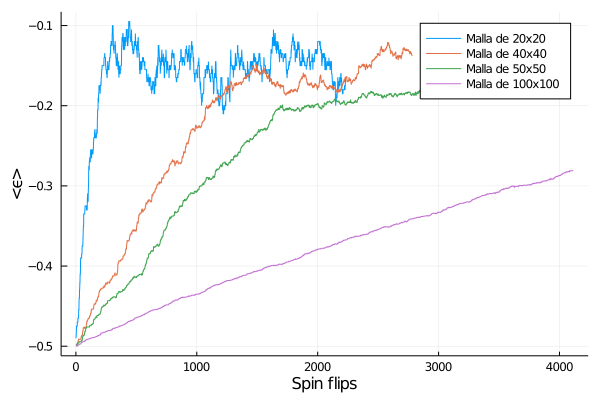

In [28]:
plot!(flips_20, energias_20./20^2,label = "Malla de 20x20")
plot!(flips_40, energias_40./40^2,label = "Malla de 40x40")
plot!(flips_50, energias_50./50^2,label = "Malla de 50x50")
plot!(flips_100, energias_100./100^2,label = "Malla de 100x100")
plot!(xlabel = "Spin flips", ylabel ="<ϵ>")

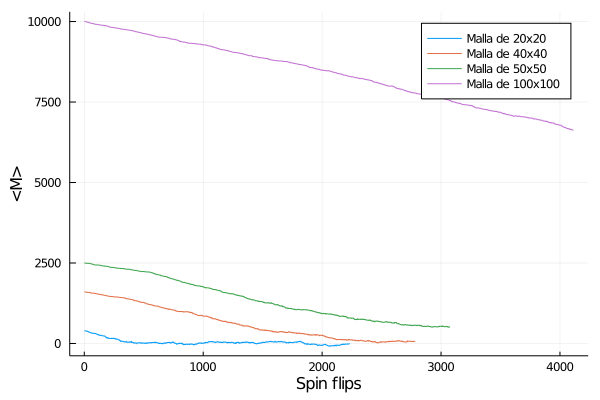

In [32]:
plot!(flips_20, M_20,label = "Malla de 20x20")
plot!(flips_40, M_40,label = "Malla de 40x40")
plot!(flips_50, M_50,label = "Malla de 50x50")
plot!(flips_100, M_100,label = "Malla de 100x100")
plot!(xlabel = "Spin flips", ylabel ="<M>")

:o el sistema tarda más en entrar en equilibrio cuando comenzamos con mayor número de spines.
Tiene sentido si consideramos que para un sistema más grande debemos hacer más cambios en sus spines para que llegue al equilibrio

### Tiempos de ejecución y estimación del número de iteraciones para terminalizar las mallas presentadas anteriormente

In [34]:
### Copiamos la función Ising que se tiene anteriormente pero ahora dejando como parámetro el número de iteraciones
#Función que modifica la red para evolucionarla a una red en equilibrio con mayor probabilidad
#Inicia recopilando la red y la temperatura y define Q como 5000 iteraciones por default
function ising_Q(red_inicial,T,Q) 
    #Obtenemos la longitud de la red
    N² = length(red_inicial)
    #hacemos una copia de la red
    red_inicial = copy(red_inicial)
    #Definimos dos arreglos donde se vaya anexando la energia total del sistema i
    E = []
    #La magnetización del i-ésimo sistema
    M = []
    #Un conteo de los volteos de spines
    flips = []
    #obtenemos los vecinos de la red, como esto sólo nos da los indices de la red no es necesario cambiar su valor
    #en cada iteración
    vecinos = generador_indice_vecinos(red_inicial)
    #Un contador del número de volteos hasta la iteración i
    flips_contador = 0
    #Iniciamos las iteraciones
    for i in 1:Q
        #Definimos el elemento al que se le cambiará el spin aleatoriamente 
        j = Int(rand(1:length(red_inicial)))
        #Obtenemos el spin inicial de la red 
        spin_inicial = red_inicial[j] 
        energia_inicial = energia_total_del_sistema(red_inicial)
        #La propuesta para cambiar el spin
        spin_final = spin_inicial*(-1)
        #hacemos una copia de la red inicial
        red_final = copy(red_inicial)
        #le cambiamos el j-ésimo elemento en la nueva red
        red_final[j] = spin_final
        #se obtiene la energía total del sistema con el spin cambiado
        energia_final = energia_total_del_sistema(red_final)
        #obtemos la diferencia de energia
        dE= energia_final-energia_inicial
        #si las condiciones se cumplen que se cambie un elemento en la red inicial
        if dE<0
            red_inicial[j] = spin_final
        elseif (rand()<exp(-dE/T))
            red_inicial[j] = spin_final
        end
        #si las redes inicial y final son diferentes que se cuente un flip 
        if red_inicial != red_final
            #y se anexe la magnetización y la energia del i-ésimo sistema
            append!(E,energia_final)
            append!(M,sum(red_inicial))
            flips_contador +=1
            append!(flips,flips_contador)
        end
    end

    return flips, E, M
end

ising_Q (generic function with 1 method)

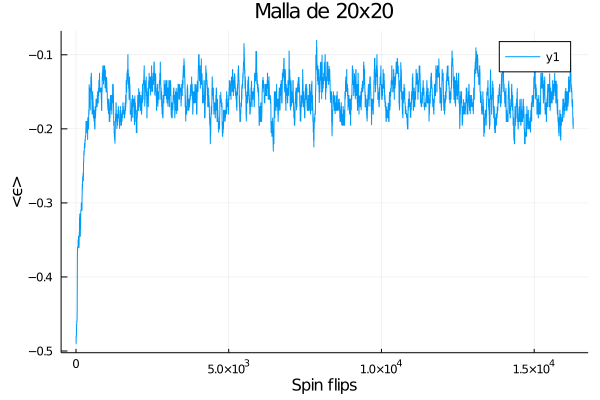

In [72]:
### Usamos las mallas del inciso anterior, solamente cambiaran el número de iteraciones
#generando mallas frías para ver en cuantos volteos se termalizan
Q_20 = 50000
flips_20_Q , energias_20_Q, M_20_Q = ising_Q(malla_20x20,1.5,Q_20)
#Y graficamos <e> y <m> para ver que el sistema está termalizado
plot(flips_20_Q, energias_20_Q./20^2,xlabel = "Spin flips", ylabel ="<ϵ>",title = "Malla de 20x20")

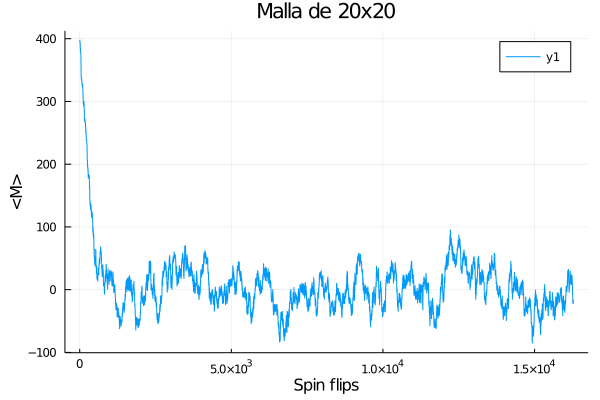

In [73]:
plot(flips_20_Q, M_20_Q,xlabel = "Spin flips", ylabel ="<M>",title = "Malla de 20x20")

El tiempo de ejecusión 

In [51]:
@benchmark ising_Q(malla_20x20,1.5,Q_20)

BenchmarkTools.Trial: 3 samples with 1 evaluation.
 Range (min … max):  1.637 s …    1.888 s  ┊ GC (min … max):  9.22% … 9.32%
 Time  (median):     1.760 s               ┊ GC (median):    10.00%
 Time  (mean ± σ):   1.762 s ± 125.634 ms  ┊ GC (mean ± σ):   9.74% ± 0.82%

  █                           █                            █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  1.64 s         Histogram: frequency by time         1.89 s <

 Memory estimate: 1.37 GiB, allocs estimate: 652800.

Realizando el mismo procedimiento pero ahora para la malla de 40x40

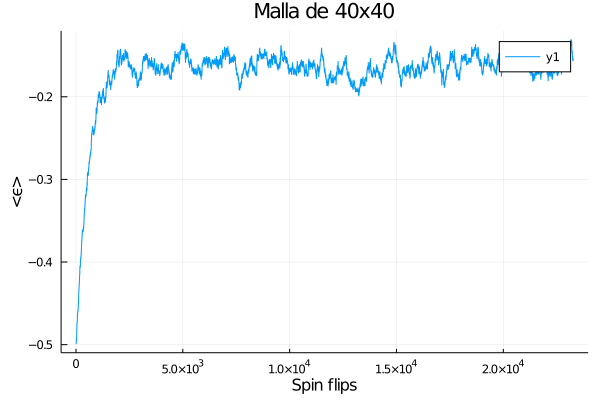

In [58]:
Q_40 = 70000
flips_40_Q , energias_40_Q, M_40_Q = ising_Q(malla_40x40,1.5,Q_40)
#Y graficamos <e> y <m> para ver que el sistema está termalizado
plot(flips_40_Q, energias_40_Q./40^2,xlabel = "Spin flips", ylabel ="<ϵ>",title = "Malla de 40x40")

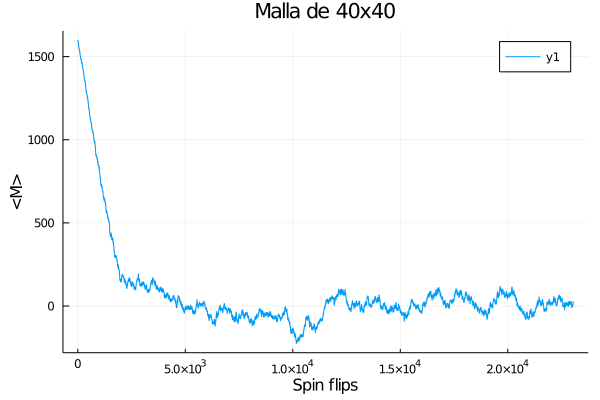

In [55]:
plot(flips_40_Q, M_40_Q,xlabel = "Spin flips", ylabel ="<M>",title = "Malla de 40x40")

In [56]:
#El tiempo de ejecusión
@benchmark ising_Q(malla_40x40,1.5,Q_40)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 9.346 s (10.62% GC) to evaluate,
 with a memory estimate of 7.54 GiB, over 1135380 allocations.

#Ahora para la malla de 50x50

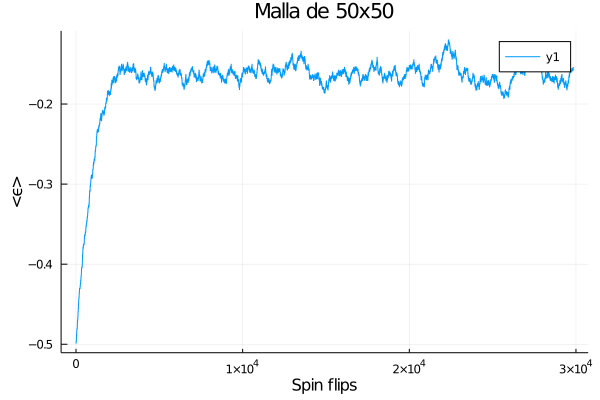

In [59]:
/

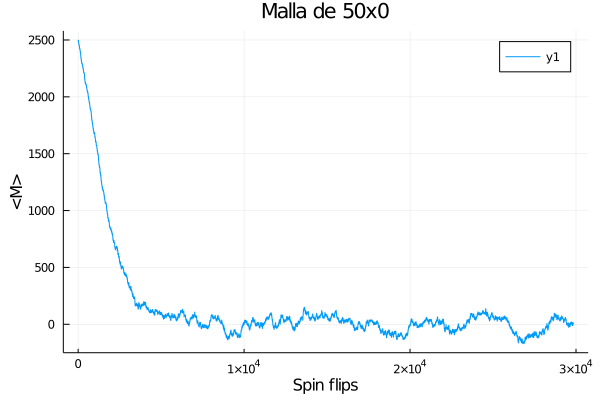

In [61]:
plot(flips_50_Q, M_50_Q,xlabel = "Spin flips", ylabel ="<M>",title = "Malla de 50x50")

In [62]:
#El tiempo de ejecusión
@benchmark ising_Q(malla_50x50,1.5,Q_50)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 17.677 s (8.83% GC) to evaluate,
 with a memory estimate of 15.13 GiB, over 1631321 allocations.

Por último para la malla de 50x50

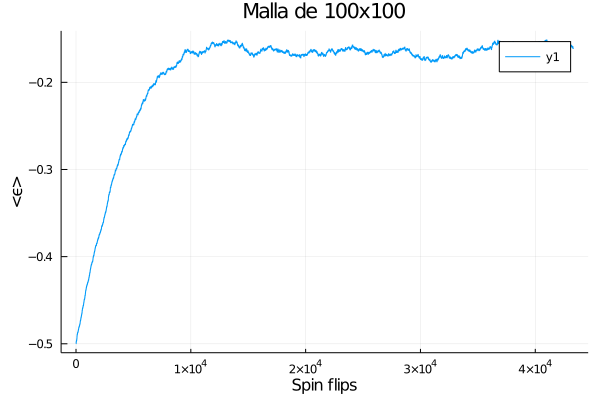

In [68]:
Q_100 = 125000
flips_100_Q , energias_100_Q, M_100_Q = ising_Q(malla_100x100,1.5,Q_100)
#Y graficamos <e> y <m> para ver que el sistema está termalizado
plot(flips_100_Q, energias_100_Q./100^2,xlabel = "Spin flips", ylabel ="<ϵ>",title = "Malla de 100x100")

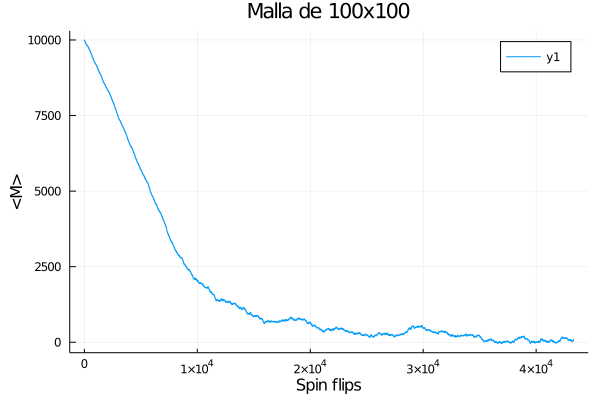

In [69]:
plot(flips_100_Q, M_100_Q,xlabel = "Spin flips", ylabel ="<M>",title = "Malla de 100x100")

In [70]:
#El tiempo de ejecusión
@benchmark ising_Q(malla_100x100,1.5,Q_100)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 76.404 s (6.83% GC) to evaluate,
 with a memory estimate of 83.87 GiB, over 2283938 allocations.

Ahora comparamos las gráficas anteriores en una sola:

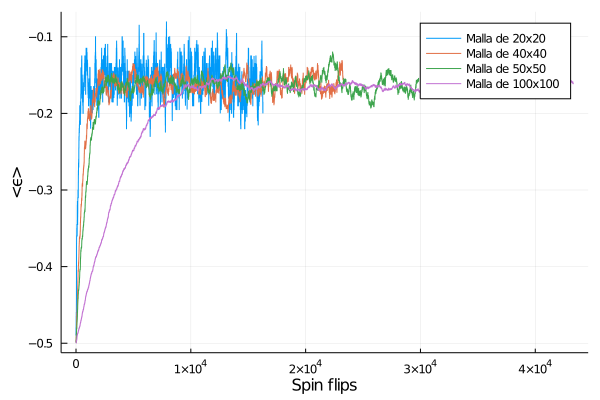

In [77]:
plot!(flips_20_Q, energias_20_Q./20^2,label = "Malla de 20x20")
plot!(flips_40_Q, energias_40_Q./40^2,label = "Malla de 40x40")
plot!(flips_50_Q, energias_50_Q./50^2,label = "Malla de 50x50")
plot!(flips_100_Q, energias_100_Q./100^2,label = "Malla de 100x100")
plot!(xlabel = "Spin flips", ylabel ="<ϵ>",tile = "Comparación de <\epsilon>")

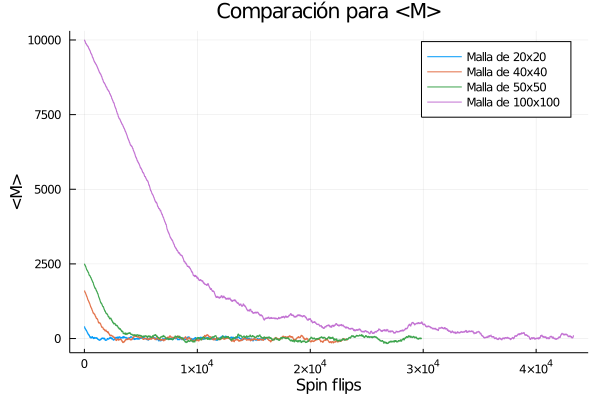

In [82]:
plot!(flips_20_Q, M_20_Q,label = "Malla de 20x20")
plot!(flips_40_Q, M_40_Q,label = "Malla de 40x40")
plot!(flips_50_Q, M_50_Q,label = "Malla de 50x50")
plot!(flips_100_Q, M_100_Q,label = "Malla de 100x100")
plot!(xlabel = "Spin flips", ylabel ="<M>",title = "Comparación para <M>")

### Calculando cuanto tiempo se tarda en pasar de un estado frío a uno caliente

### Obtención de las raíces

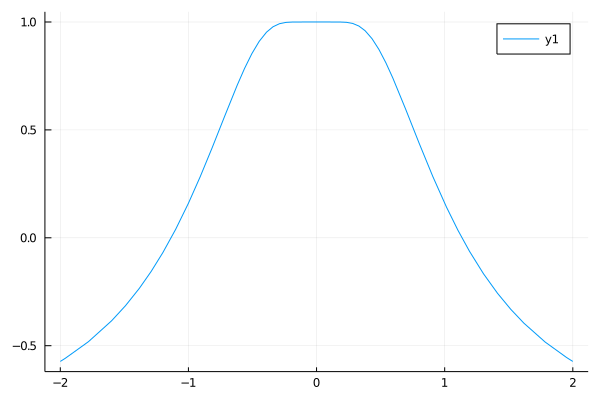

In [9]:
f(x) = 2*(tanh(2*0.5/(kb*x)))^2-1
plot(f, -2 ,2)


In [10]:
Tc = find_zeros(f, 0, 5) 

1-element Array{Float64,1}:
 1.1345926571065108